# CI model of IGF/EGF signaling pathway

In [95]:
# Load packages
from MScausality.causal_model.LVM import LVM
from MScausality.simulation.simulation import simulate_data
import MScausality.data_analysis.normalization as norm
import MScausality.data_analysis.gene_set as gs

import pandas as pd
import numpy as np
import random
import pyro

import networkx as nx
import y0
from y0.dsl import Variable

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Construct graph

In [97]:
def build_igf_network():
    """
    Create IGF graph in networkx

    """
    graph = nx.DiGraph()

    ## Add edges
    # Confounding edges
    graph.add_edge("EGF", "SOS_PTM")
    graph.add_edge("EGF", "PI3K_PTM")
    graph.add_edge("IGF", "SOS_PTM")
    graph.add_edge("IGF", "PI3K_PTM")

    # SOS
    graph.add_edge("SOS", "SOS_PTM")
    graph.add_edge("SOS_PTM", "Ras_PTM")

    # Ras
    graph.add_edge("Ras", "Ras_PTM")
    graph.add_edge("Ras_PTM", "PI3K_PTM")

    # PI3K
    graph.add_edge("PI3K", "PI3K_PTM")
    graph.add_edge("Ras_PTM", "PI3K_PTM")

    # Akt
    graph.add_edge("Akt", "Akt_PTM")
    graph.add_edge("PI3K_PTM", "Akt_PTM")

    # Raf
    graph.add_edge("Raf", "Raf_PTM")
    graph.add_edge("Ras_PTM", "Raf_PTM")
    graph.add_edge("Akt_PTM", "Raf_PTM")
    
    # Mek
    graph.add_edge("Mek", "Mek_PTM")
    graph.add_edge("Raf_PTM", "Mek_PTM")

    # Erk
    graph.add_edge("Erk", "Erk_PTM")
    graph.add_edge("Mek_PTM", "Erk_PTM")
    
    return graph

def build_admg(graph):
    ## Define obs vs latent nodes
    all_nodes = ["SOS", "SOS_PTM", 
                 "PI3K", "PI3K_PTM",
                 "Ras", "Ras_PTM",
                 "Raf", "Raf_PTM", 
                 "Akt", "Akt_PTM", 
                 "Mek", "Mek_PTM",
                 "Erk", "Erk_PTM", 
                 "EGF", "IGF"]
    obs_nodes = ["SOS", "SOS_PTM", 
                 "PI3K", "PI3K_PTM",
                 "Ras", "Ras_PTM",
                 "Raf", "Raf_PTM", 
                 "Akt", "Akt_PTM", 
                 "Mek", "Mek_PTM",
                 "Erk", "Erk_PTM"]
    latent_nodes = ["EGF", "IGF"]
    
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)

    ## Use y0 to build ADMG
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(graph, "hidden")
    
    return y0_graph

def build_ptm_admg(graph):
    ## Define obs vs latent nodes
    all_nodes = ["SOS", "SOS_PTM", 
                 "PI3K", "PI3K_PTM",
                 "Ras", "Ras_PTM",
                 "Raf", "Raf_PTM", 
                 "Akt", "Akt_PTM", 
                 "Mek", "Mek_PTM",
                 "Erk", "Erk_PTM", 
                 "EGF", "IGF"]
    obs_nodes = ["SOS_PTM", 
                 "PI3K_PTM",
                 "Ras_PTM",
                 "Raf_PTM", 
                 "Akt_PTM", 
                 "Mek_PTM",
                 "Erk_PTM"]
    latent_nodes = ["EGF", "IGF"]
    
    attrs = {node: (True if node not in obs_nodes and 
                    node != "\\n" else False) for node in all_nodes}

    nx.set_node_attributes(graph, attrs, name="hidden")
    
    mapping = dict(zip(list(graph.nodes), 
                      [Variable(i) for i in list(graph.nodes)]))
    graph = nx.relabel_nodes(graph, mapping)

    ## Use y0 to build ADMG
    y0_graph = y0.graph.NxMixedGraph()
    y0_graph = y0_graph.from_latent_variable_dag(graph, "hidden")
    
    return y0_graph

In [98]:
bulk_graph = build_igf_network()
y0_graph_bulk = build_admg(bulk_graph)
y0_graph_ptm = build_ptm_admg(bulk_graph)

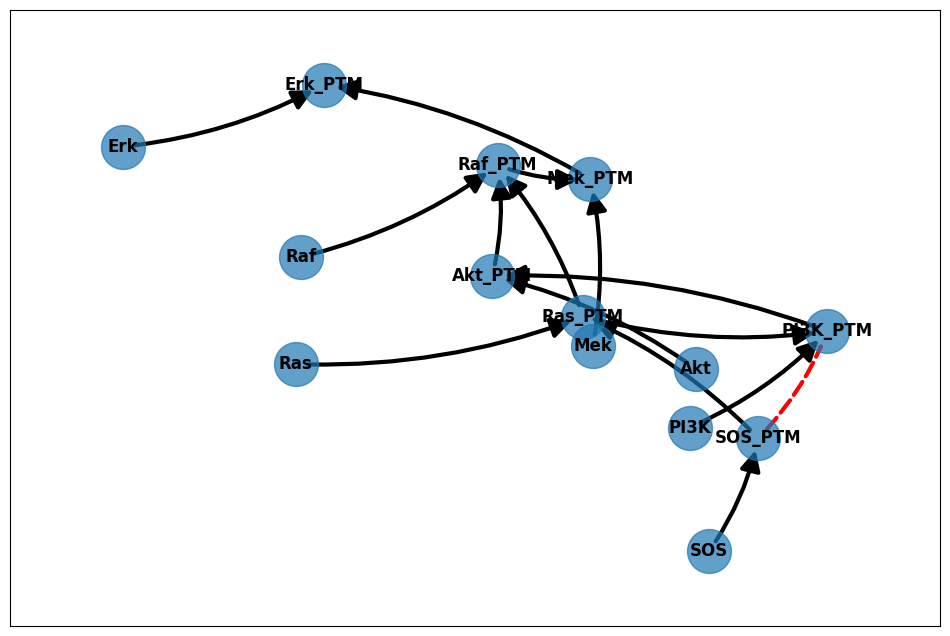

In [4]:
def plot_latent_graph(y0_graph, figure_size=(4, 3), title=None):

    ## Create new graph and specify color and shape of observed vs latent edges
    temp_g = nx.DiGraph()

    for d_edge in list(y0_graph.directed.edges):
        temp_g.add_edge(d_edge[0], d_edge[1], color="black", style='-', size=30)
    for u_edge in list(y0_graph.undirected.edges):
        if temp_g.has_edge(u_edge[0], u_edge[1]):
            temp_g.add_edge(u_edge[1], u_edge[0], color="red", style='--', size=1)
        else:
            temp_g.add_edge(u_edge[0], u_edge[1], color="red", style='--', size=1)

    ## Extract edge attributes
    # pos = nx.random_layout(temp_g)
    pos = nx.spring_layout(temp_g)
    edges = temp_g.edges()
    colors = [temp_g[u][v]['color'] for u, v in edges]
    styles = [temp_g[u][v]['style'] for u, v in edges]
    arrowsizes = [temp_g[u][v]['size'] for u, v in edges]

    ## Plot
    fig, ax = plt.subplots(figsize=figure_size)
    nx.draw_networkx_nodes(temp_g, pos=pos, node_size=1000, margins=[.1, .1], alpha=.7)
    nx.draw_networkx_labels(temp_g, pos=pos, font_weight='bold')
    nx.draw_networkx_edges(temp_g, pos=pos, ax=ax, connectionstyle='arc3, rad = 0.1',
                           edge_color=colors, width=3, style=styles, arrowsize=arrowsizes)
    if title is not None:
        ax.set_title(title)
    plt.show()
    
plot_latent_graph(y0_graph_bulk, figure_size=(12, 8))

## Ground truth invervention

Generate interventional data using the ground truth network for comparison.

In [5]:
## Coefficients for relations
ptm_coef = {   
    'EGF': {'intercept': 19., "error": 1},
    'IGF': {'intercept': 17., "error": 1},
    
    #SOS
    'SOS': {'intercept': 15, "error": .5},
    'SOS_PTM': {'intercept': 0, "error": .5, 'SOS': .7, 'EGF': 0.5, 'IGF': 0.5},
    
    #Ras
    'Ras': {'intercept': 10, "error": .5},
    'Ras_PTM': {'intercept': 0, "error": .5, 'Ras' : .6, 'SOS_PTM': .5},
    
    #PI3K
    'PI3K': {'intercept': 12, "error": .5},
    'PI3K_PTM': {'intercept': 0, "error": .5, 'PI3K':.7, 'EGF': .5, 'IGF': .5, 'Ras_PTM': .5},

    #Akt
    'Akt': {'intercept': 8., "error": .5},
    'Akt_PTM': {'intercept': 0, "error": .5, 'Akt': .5, 'PI3K_PTM': 0.75},

    #Raf
    'Raf': {'intercept': 10, "error": .5},
    'Raf_PTM': {'intercept': 0, "error": .5, 'Raf': .65, 'Ras_PTM': 0.8, 'Akt_PTM': -.4},

    # Mek
    'Mek': {'intercept': 14., "error": .5},
    'Mek_PTM': {'intercept': 0, "error": .5, 'Mek': .55, 'Raf_PTM': 0.75},

    # Erk
    'Erk': {'intercept': 9., "error": .5},
    'Erk_PTM': {'intercept': 0, "error": .5, 'Erk': .7, 'Mek_PTM': 1.2}
    
    }

Some code to test if the coefficients make sense

In [18]:
gt_sim = simulate_data(bulk_graph,
                  coefficients=ptm_coef,
                  include_missing=True,
                  mar_missing_param=.05,
                  mnar_missing_param=[-3, .4],
                  n=1000,
                  seed=None)

# for key, val in test["Protein_data"].items():

#     fig, ax = plt.subplots()
#     ax.hist(val, bins=15)
#     ax.set_title(key)

simulating data...
adding feature level data...
masking data...


In [102]:
int_sim15 = simulate_data(bulk_graph,
                  coefficients=ptm_coef,
                  include_missing=True,
                  mar_missing_param=.05,
                  mnar_missing_param=[-3, .4],
                  intervention={'Ras_PTM': 15},
                  n=1000,
                  seed=None)

simulating data...
adding feature level data...
masking data...


In [103]:
int_sim20 = simulate_data(bulk_graph,
                  coefficients=ptm_coef,
                  include_missing=True,
                  mar_missing_param=.05,
                  mnar_missing_param=[-3, .4],
                  intervention={'Ras_PTM': 20},
                  n=1000,
                  seed=None)

simulating data...
adding feature level data...
masking data...


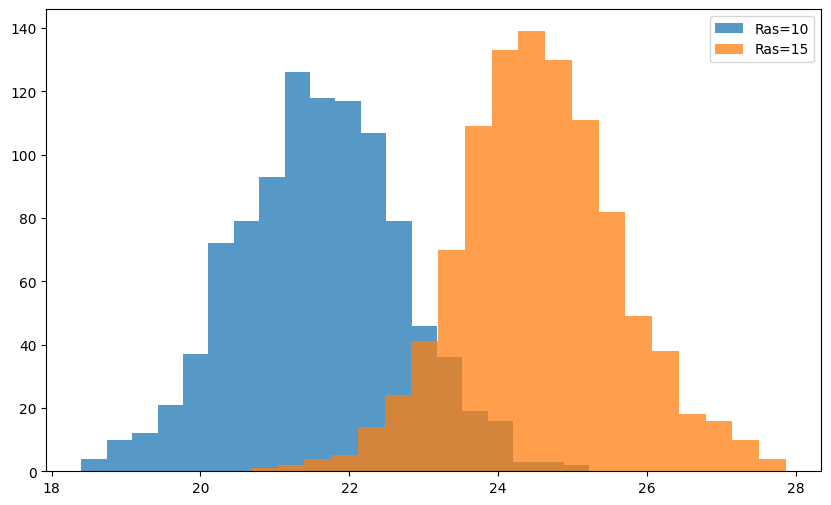

In [104]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(int_sim15["Protein_data"]["Erk_PTM"], label="Ras=10", alpha=.75, bins=20)
ax.hist(int_sim20["Protein_data"]["Erk_PTM"], label="Ras=15", alpha=.75, bins=20)
ax.legend()


## Simulate data

In [90]:
n_conditions = 50

ptm_con_list = list()
protein_con_list = list()

for i in range(n_conditions):
    
    node = random.sample(list(bulk_graph.nodes()), 1)[0]
    int_val = np.random.uniform(5, 25)

    temp_ptm_data = simulate_data(bulk_graph, coefficients=ptm_coef, include_missing=True,
                       mar_missing_param=.05, mnar_missing_param=[-3, .4], 
                       intervention={node: int_val},
                       n=10, seed=None)["Feature_data"]

    temp_protein_data = simulate_data(bulk_graph, coefficients=ptm_coef, include_missing=True,
                        mar_missing_param=.05, mnar_missing_param=[-3, .4], 
                        intervention={node: int_val},
                        n=5, seed=None)["Feature_data"]
    
    temp_ptm_data = temp_ptm_data.loc[
        temp_ptm_data["Protein"].str.contains("PTM")]
    temp_protein_data = temp_protein_data.loc[
        -temp_protein_data["Protein"].str.contains("PTM")]

    temp_ptm_data.loc[:, "Condition"] = i
    temp_protein_data.loc[:, "Condition"] = i

    ptm_con_list.append(temp_ptm_data)
    protein_con_list.append(temp_protein_data)

    
dmso_ptm_data = simulate_data(bulk_graph, coefficients=ptm_coef, include_missing=True,
                       mar_missing_param=.05, mnar_missing_param=[-3, .4], 
                       n=100, seed=None)

dmso_protein_data = simulate_data(bulk_graph, coefficients=ptm_coef, include_missing=True,
                       mar_missing_param=.05, mnar_missing_param=[-3, .4], 
                       n=50, seed=None)

ptm_data_subset = dmso_ptm_data["Feature_data"].loc[
    dmso_ptm_data["Feature_data"]["Protein"].str.contains("PTM")]
protein_data_subset = dmso_protein_data["Feature_data"].loc[
    -dmso_protein_data["Feature_data"]["Protein"].str.contains("PTM")]

ptm_data_subset.loc[:, "Condition"] = "DMSO"
protein_data_subset.loc[:, "Condition"] = "DMSO"

ptm_con_list.append(ptm_data_subset)
protein_con_list.append(protein_data_subset)

ptm_data = pd.concat(ptm_con_list, ignore_index=True)
protein_data = pd.concat(protein_con_list, ignore_index=True)

ptm_data.to_csv("../../data/IGF_PTM_pathway/ptm_feature_data.csv", index=False)
protein_data.to_csv("../../data/IGF_PTM_pathway/protein_feature_data.csv", index=False)

simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level data...
masking data...
simulating data...
adding feature level 

In [91]:
len(ptm_data)

46030

In [92]:
len(protein_data)

30650

- Two models
    - PTM only (Protein latent)
    - Fold change model
- PTM only
    - Just run it thru and get accuracy
- FC model
    - simulate interventions
    - Run through MSstatsPTM to get FC
    - Train model with FC

## PTM Only

In [117]:
ptm_only_data = pd.read_csv("../../data/IGF_PTM_pathway/ptm_summarized_data.csv")
ptm_only_data.head()

,originalRUN,Akt_PTM,Erk_PTM,Mek_PTM,PI3K_PTM,Raf_PTM,Ras_PTM,SOS_PTM
0,0_0_0,30.391829,29.882651,19.682914,34.696098,17.100858,20.369116,27.869098
1,0_1_0,30.375838,31.883531,20.188082,35.491762,19.050159,21.194789,27.846365
2,0_2_0,31.494127,32.254465,21.516450,34.957714,16.899028,19.999173,27.936467
3,0_3_0,31.815852,29.856360,19.168087,36.421492,18.179742,20.837952,27.829932
4,0_4_0,30.699955,30.306819,19.657759,35.204738,18.464778,20.271887,27.598409


In [118]:
pyro.clear_param_store()

lvm = LVM(ptm_only_data.loc[:, 
        [i for i in ptm_only_data.columns != "originalRUN"]], 
          y0_graph_ptm)
lvm.prepare_graph()
lvm.prepare_data()
lvm.fit_model(num_steps=2000)

lvm.intervention({"Ras_PTM": 15}, "Erk_PTM")
first_int = lvm.intervention_samples
lvm.intervention({"Ras_PTM": 20}, "Erk_PTM")
second_int = lvm.intervention_samples

Step 0: Loss = 1234880.2754703509
Step 100: Loss = 9000.823478639126
Step 200: Loss = 4259.451238036156
Step 300: Loss = 2381.5476419627666
Step 400: Loss = 1457.9445870220661
Step 500: Loss = 683.4086344242096
Step 600: Loss = 346.37169166095555
Step 700: Loss = -168.2884476967156
Step 800: Loss = -353.78752648085356
Step 900: Loss = -539.80425433442
Step 1000: Loss = -730.7138291315641
Step 1100: Loss = -861.4073048532009
Step 1200: Loss = -964.8040636628866
Step 1300: Loss = -1035.8606388941407
Step 1400: Loss = -1034.2730274656788
Step 1500: Loss = -1130.0404033660889
Stopping early at step 1579 with loss -1141.8952072439715


[Text(1, 0.0, ''),
 Text(1, 500.0, ''),
 Text(1, 1000.0, ''),
 Text(1, 1500.0, ''),
 Text(1, 2000.0, ''),
 Text(1, 2500.0, ''),
 Text(1, 3000.0, ''),
 Text(1, 3500.0, '')]

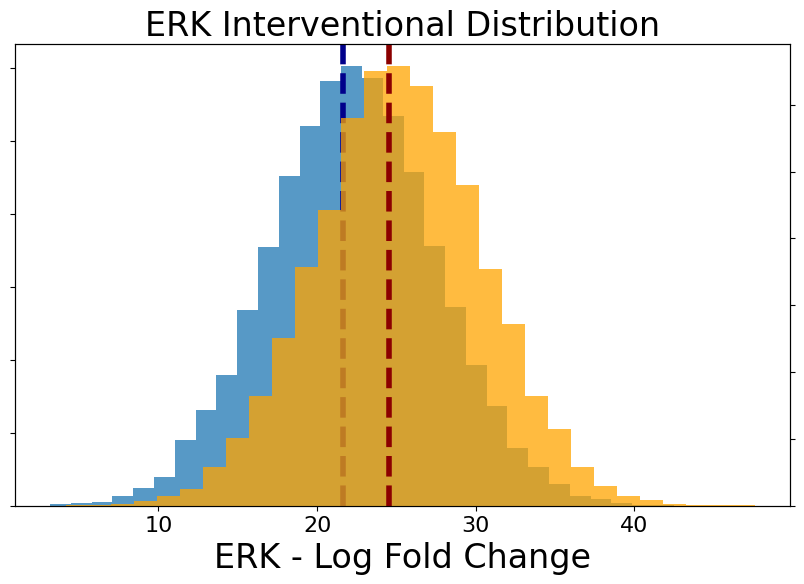

In [119]:
fig, ax = plt.subplots(figsize=(10,6))

adj = 0#np.mean(np.array(cell_sim_protein_data.loc[:, "Erk"].values))

ax.hist(np.array(first_int) - adj, bins=30, alpha=.75, label="Observational Data")
ax.axvline(np.mean(np.array(int_sim15["Protein_data"]["Erk_PTM"])), color="darkblue", linestyle="dashed", lw=4)

ax2 = ax.twinx()
ax2.hist(np.array(second_int) - adj, bins=30, alpha=.75, label="Interventional Distribution", color="orange")
ax2.axvline(np.mean(np.array(int_sim20["Protein_data"]["Erk_PTM"])) - adj, color="darkred", linestyle="dashed", lw=4)

# ax.legend(fontsize=20)
ax.set_title("ERK Interventional Distribution", size=24)
ax.set_xlabel("ERK - Log Fold Change", size=24)
# ax.set_ylabel("Erk", size=24)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.set_yticklabels([])
ax2.set_yticklabels([])

# ax.set_xlim(-5,40)
# ax.set_ylim(0,1800)

In [121]:
np.mean(np.array(second_int)) - np.mean(np.array(first_int))

2.9596863

## FC_model

In [123]:
fc_data = pd.read_csv("../../data/IGF_PTM_pathway/fc_model.csv")
fc_data.head()

,Label,Akt_PTM,Erk_PTM,Mek_PTM,PI3K_PTM,Raf_PTM,Ras_PTM,SOS_PTM,Akt,EGF,Erk,IGF,Mek,PI3K,Raf,Ras,SOS
0,0-DMSO,0.320786,5.501510,4.162991,-0.274767,7.568341,0.547771,-0.572989,-1.045486,-0.789458,-0.717000,0.638359,-0.175177,1.207038,10.561501,-0.791015,0.801324
1,1-DMSO,-1.907962,-4.297174,-2.576420,-1.601589,-2.394906,-4.505793,-9.619558,0.560165,0.701387,0.245909,2.009430,-0.102665,0.304736,-0.350312,-0.937619,-0.362456
2,10-DMSO,-0.131174,8.474378,6.731468,0.834312,10.429573,-0.468312,-0.681535,-0.531607,0.026404,-0.121852,1.796811,-0.697909,1.210270,0.455395,-0.637492,0.280164
3,11-DMSO,5.870534,-2.558948,-2.505734,0.760729,-1.713748,1.184618,-0.284963,8.585765,1.487923,-0.103850,0.402820,-1.624957,1.591784,0.204632,-0.100775,-0.360120
4,12-DMSO,0.500962,-0.094925,0.580263,0.288036,1.162440,0.991032,-1.284553,-1.261817,0.391493,1.201738,-0.713481,-1.049564,1.402409,0.572690,0.005233,0.521497


In [126]:
pyro.clear_param_store()

lvm = LVM(
    fc_data.loc[:, [i for i in fc_data.columns != "Label"]], 
    y0_graph_bulk)
lvm.prepare_graph()
lvm.prepare_data()
lvm.fit_model(num_steps=2000)

lvm.intervention({"Ras_PTM": 15}, "Erk_PTM")
first_int = lvm.intervention_samples
lvm.intervention({"Ras_PTM": 20}, "Erk_PTM")
second_int = lvm.intervention_samples

Step 0: Loss = -10.575426332652569
Step 100: Loss = -242.83149582054466
Step 200: Loss = -414.60749727487564
Step 300: Loss = -511.15662732720375
Step 400: Loss = -564.1487826108932
Step 500: Loss = -604.1860684007406
Step 600: Loss = -603.0277330130339
Step 700: Loss = -668.4530281871557
Step 800: Loss = -700.8602959662676
Step 900: Loss = -672.5049058757722
Stopping early at step 975 with loss -747.031215839088


[Text(1, 0.0, ''),
 Text(1, 50.0, ''),
 Text(1, 100.0, ''),
 Text(1, 150.0, ''),
 Text(1, 200.0, ''),
 Text(1, 250.0, '')]

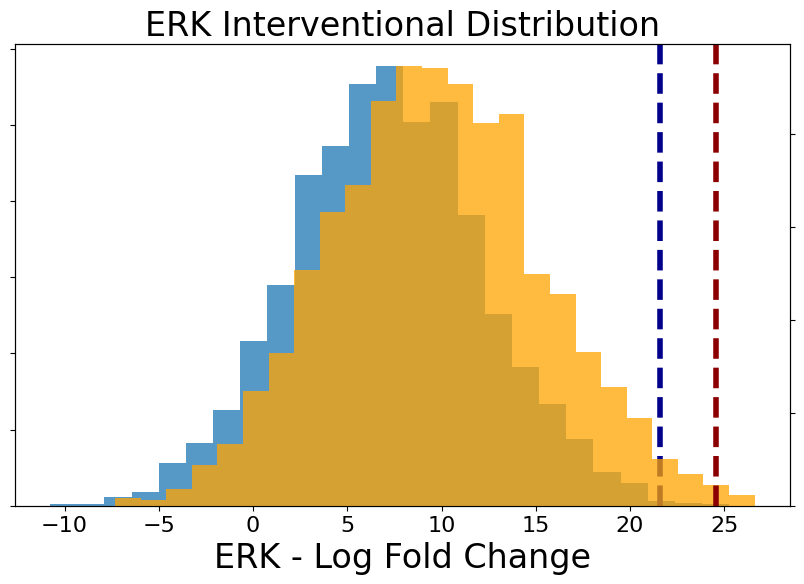

In [130]:
fig, ax = plt.subplots(figsize=(10,6))

adj = 0#np.mean(np.array(cell_sim_protein_data.loc[:, "Erk"].values))

ax.hist(np.array(first_int) - adj, bins=25, alpha=.75, label="Observational Data")
ax.axvline(np.mean(np.array(int_sim15["Protein_data"]["Erk_PTM"])), color="darkblue", linestyle="dashed", lw=4)

ax2 = ax.twinx()
ax2.hist(np.array(second_int) - adj, bins=25, alpha=.75, label="Interventional Distribution", color="orange")
ax2.axvline(np.mean(np.array(int_sim20["Protein_data"]["Erk_PTM"])) - adj, color="darkred", linestyle="dashed", lw=4)

# ax.legend(fontsize=20)
ax.set_title("ERK Interventional Distribution", size=24)
ax.set_xlabel("ERK - Log Fold Change", size=24)
# ax.set_ylabel("Erk", size=24)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.set_yticklabels([])
ax2.set_yticklabels([])

# ax.set_xlim(-5,40)
# ax.set_ylim(0,1800)

In [128]:
np.mean(np.array(int_sim20["Protein_data"]["Erk_PTM"])) - np.mean(np.array(int_sim15["Protein_data"]["Erk_PTM"]))

2.960471683178895

In [129]:
np.mean(np.array(second_int)) - np.mean(np.array(first_int))

2.6326532